In [1]:
# !pip install antspyx

In [2]:
# !pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


### Original size

In [1]:
from pathlib import Path

thispath = Path('__file__').resolve()
base_path = thispath.parent.parentceil
import sys; sys.path.insert(0, str(base_path))
from dataset.copd_dataset import DirLabCOPD

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import preprocess.preprocess as preprocess
from dataset.copd_dataset import DirLabCOPD
from utils import metrics

In [5]:
import time

In [3]:
# Dataset
data_path = Path('/home/kaouther/Documents/GitHub/mira_final_project/data')

NORMALIZATION_CFG = {
    'norm_type': 'min-max',
    'mask': None,
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}

data = DirLabCOPD(
    data_path=data_path,
    cases=['all'],
    partitions=['train'],
    return_lm_mask=True,
    normalization_cfg=None,
    return_body_masks=False,
    return_lung_masks=False
)

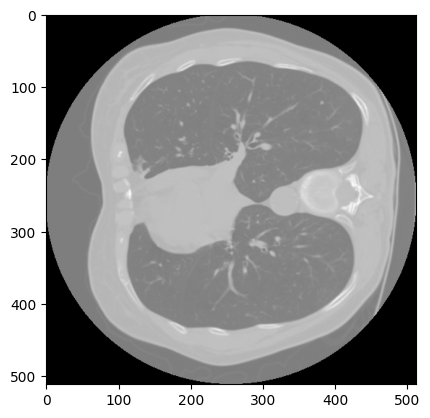

In [7]:
# for i in range(len(data)):
#     sample = data[i]
#     plt.figure()
#     plt.imshow(sample['i_img'][:,:,75], cmap='gray')
#     plt.show()
#     break

In [4]:
import ants
import numpy as np
from pathlib import Path

In [6]:
from scipy.spatial.distance import euclidean
from typing import Tuple


def target_registration_error(
    pts_i: np.ndarray, pts_e: np.ndarray, voxel_size: Tuple[float]
) -> Tuple[float]:
    """ Computes the mean and standard deviation for target registration error in mm
    between two arrays of sorted points.
    Warning: The points should have the same order in each array

    Args:
        pts_i (np.ndarray): _description_
        pts_e (np.ndarray): _description_
        voxel_size (Tuple[float]): _description_
    Returns:
        float: Target registration error mean
        float: Target registration error standard deviation
    """
    voxel_size = np.array(voxel_size)[None, :]
    pts_i = pts_i * voxel_size
    pts_e = pts_e * voxel_size
    distances = [euclidean(pt1, pt2) for pt1, pt2 in zip(pts_i, pts_e)]
    return np.around(np.mean(distances), 2), np.around(np.std(distances), 2)

In [6]:
plot = False
sample = data[0]
# sample

In [7]:
sample = data[0]
fixed = ants.image_read(sample['e_img_path']) 
spacing = fixed.spacing
origin = fixed.origin
direction = fixed.direction

In [8]:
# fixed = ants.image_read(sample['e_img_path'])  #.resample_image((256,256, 64), 1, 0)
# moving = ants.image_read(sample['i_img_path'])  #.resample_image((256,256, 64), 1, 0)


fixed = ants.from_numpy(sample['e_img'].astype(np.float64), spacing=spacing, direction=direction, origin=origin)# .resample_image((256,256, 64), 1, 0)
moving = ants.from_numpy(sample['i_img'].astype(np.float64), spacing=spacing, direction=direction, origin=origin)#.resample_image((256,256, 64), 1, 0)

In [ ]:
# fixed_lung_mask = ants.from_numpy(sample['e_lung_mask'].astype(np.float64), origin=origin, spacing=spacing, direction=direction)#.resample_image((256,256, 64), 1, 0)
# moving_lung_mask = ants.from_numpy(sample['i_lung_mask'].astype(np.float64), origin=origin, spacing=spacing, direction=direction)#.resample_image((256,256, 64), 1, 0)

In [9]:
# fixed.plot(overlay=fixed_lung_mask, title='Fixed + Lung mask', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [10]:
# moving.plot(overlay=moving_lung_mask, title='Moving + Lung mask', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [11]:
fixed_rescaled = ants.iMath(fixed, 'Normalize', 0.0, 1.0)
# fixed_rescaled.plot(axis=2)

In [12]:
fixed_trunc = ants.iMath_truncate_intensity( fixed_rescaled, 0.05, 0.95 )
# fixed_trunc.plot(axis=2)

In [13]:
moving_rescaled = ants.iMath(moving, 'Normalize', 0.0, 1.0)
moving_trunc = ants.iMath_truncate_intensity(moving_rescaled, 0.05, 0.95 )

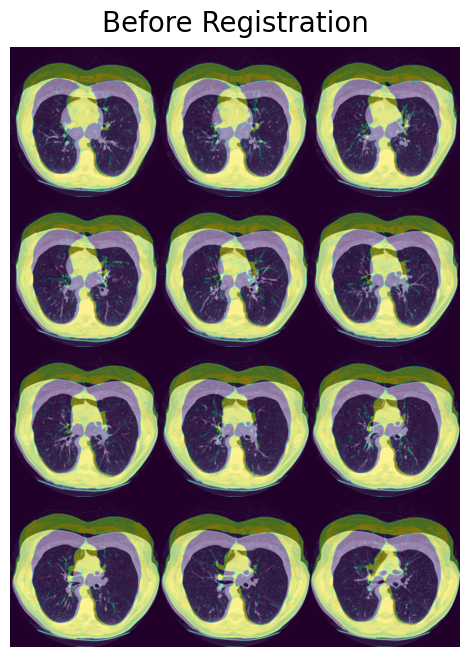

In [14]:
fixed_trunc.plot(overlay=moving_trunc, title='Before Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [16]:
import time
start = time.time()
mytx = ants.registration(fixed=fixed_trunc, 
                         moving=moving_trunc, 
                         outprefix='/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms/',
                         type_of_transform="SyNOnly",
                         reg_iterations=(10, 10, 5),
                         syn_metric='meansquares',
                         verbose=True)
end = time.time() - start 
print(end)

antsRegistration -d 3 -r [0x55f2ce924890,0x55f2d3324300,1] -m meansquares[0x55f2ce924890,0x55f2d3324300,1,32] -t SyN[0.200000,3.000000,0.000000] -c [10x10x5,1e-7,8] -s 2x1x0 -f 4x2x1 -u 1 -z 1 -o [/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms/,0x55f2cee832d0,0x55f2cf2b6ae0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x55f2ce924890 and moving image: 0x55f2d3324300 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 3
  fixed image: 0x55f2ce924890
  moving image: 0x55f2d3324300
Dimension = 3
Number of stages = 1
Use Histogram Matching true
Winsorize image intensities false
Lower quantile = 0
Upper quantile = 1
Stage 1 State
   Image metric = MeanSquares
     Fixed image = Image (0x55f2d3323d70)
 

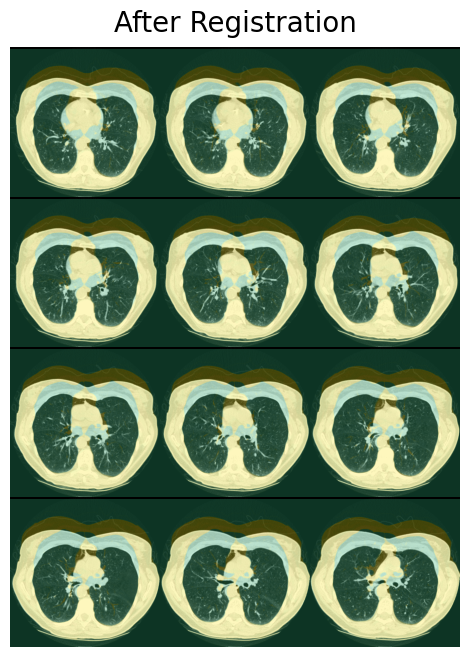

In [17]:
warped_moving = mytx['warpedmovout']
fixed_trunc.plot(overlay=warped_moving, cmap='gray', overlay_cmap='viridis', overlay_alpha=0.3, title='After Registration', axis=2)

In [ ]:
mytx['fwdtransforms']

['/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms/1Warp.nii.gz',
 '/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms/0GenericAffine.mat']

In [18]:
def_field = ants.image_read(mytx['fwdtransforms'][0])
fwdtransform = ants.transform_from_displacement_field(def_field)
mywarped = fwdtransform.apply_to_image(moving_trunc)
fixed_trunc.plot(overlay=mywarped, cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, title='After Registration', axis=2)

In [ ]:
# mywarped_mask = fwdtransform.apply_to_image(moving_lung_mask, interpolation='nearestneighbor')

In [22]:
# fixed_trunc.plot(overlay=moving_lung_mask, cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, title='After Registration', axis=2)

In [23]:
# fixed_trunc.plot(overlay=mywarped_mask, cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, title='After Registration', axis=2)

In [27]:
landmarks_moving = sample['i_landmark_pts']
landmarks_fixed = sample['e_landmark_pts']
landmarks_result = np.zeros_like(landmarks_moving)

for i in range(len(landmarks_moving)):
    pt = landmarks_moving[i]  
    res = fwdtransform.apply_to_point(pt)
    landmarks_result[i, :] = res

tre = target_registration_error(landmarks_result, landmarks_fixed, spacing)
print(f'TRE estimated: {tre[0]}, {tre[1]}')  
print(f'Initial displacement GT: {sample["disp_mean"]}, {sample["disp_mean"]}')

TRE estimated: 26.33, 11.42
Initial displacement GT: 25.9, 25.9


TRE estimated: 21.79, 6.46
Initial displacement GT: 21.77, 21.77


In [28]:

import pandas as pd
df_lm_moving = pd.DataFrame(sample['i_landmark_pts'], columns = ['x','y','z'])

landmarks_result = ants.apply_transforms_to_points(3, df_lm_moving, mytx['fwdtransforms'], whichtoinvert=[False, True])

landmarks_array_res = landmarks_result.to_numpy(dtype=np.float64)

landmarks_array_gt = sample['e_landmark_pts']

tre = target_registration_error(landmarks_array_res, landmarks_array_gt, fixed.spacing)
print(f'TRE estimated: {tre[0]}, {tre[1]}')  
print(f'Initial displacement GT: {sample["disp_mean"]}, {sample["disp_mean"]}')



TRE estimated: 25.22, 11.41
Initial displacement GT: 25.9, 25.9


### Trying with downsampling

In [2]:
from pathlib import Path

thispath = Path('__file__').resolve()
base_path = thispath.parent.parent
import sys; sys.path.insert(0, str(base_path))
from dataset.copd_dataset import DirLabCOPD
import matplotlib.pyplot as plt
import preprocess.preprocess as preprocess
from utils import metrics

import ants
import numpy as np
import time 
import pandas as pd

In [3]:
# Dataset
data_path = Path('/home/kaouther/Documents/GitHub/mira_final_project/data')

NORMALIZATION_CFG = {
    'norm_type': 'min-max',
    'mask': None,
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}

data = DirLabCOPD(
    data_path=data_path,
    cases=['all'],
    partitions=['train'],
    return_lm_mask=False,
    normalization_cfg=NORMALIZATION_CFG,
    return_body_masks=False,
    return_lung_masks=False
)

In [4]:
sample = data[0]
fixed = ants.image_read(sample['e_img_path'])
original_size = fixed.shape
spacing = fixed.spacing
origin = fixed.origin
direction = fixed.direction

KeyboardInterrupt: 

In [ ]:
new_size = tuple(np.floor((np.array(fixed.shape)/2)).astype(int))

In [ ]:
fixed = ants.from_numpy(sample['e_img'].astype(np.float64), spacing=spacing, direction=direction, origin=origin).resample_image(new_size, 1, 0)
moving = ants.from_numpy(sample['i_img'].astype(np.float64), spacing=spacing, direction=direction, origin=origin).resample_image(new_size, 1, 0)

In [41]:
fixed.shape

(256, 256, 60)

In [42]:
fixed = ants.iMath(fixed, 'Normalize', 0.0, 1.0)
fixed = ants.iMath_truncate_intensity(fixed, 0.05, 0.95 )

moving = ants.iMath(moving, 'Normalize', 0.0, 1.0)
moving = ants.iMath_truncate_intensity(moving, 0.05, 0.95 )

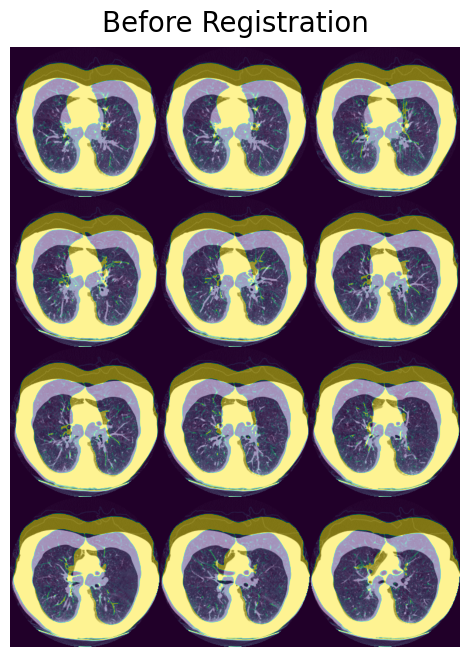

In [43]:
fixed.plot(overlay=moving, title='Before Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [44]:
start = time.time()
mytx = ants.registration(fixed=fixed, 
                         moving=moving, 
                         outprefix='/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms/',
                         type_of_transform="SyNOnly",
                         reg_iterations=(60, 30, 15),
                         syn_metric='meansquares',
                         verbose=True)
end = time.time() - start 
print(end)

antsRegistration -d 3 -r [0x5609d61fb160,0x5609e00624c0,1] -m meansquares[0x5609d61fb160,0x5609e00624c0,1,32] -t SyN[0.200000,3.000000,0.000000] -c [60x30x15,1e-7,8] -s 2x1x0 -f 4x2x1 -u 1 -z 1 -o [/home/kaouther/Documents/GitHub/mira_final_project/ants/transforms/,0x5609dde4c8a0,0x5609d5926060] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x5609d61fb160 and moving image: 0x5609e00624c0 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 3
  fixed image: 0x5609d61fb160
  moving image: 0x5609e00624c0
Dimension = 3
Number of stages = 1
Use Histogram Matching true
Winsorize image intensities false
Lower quantile = 0
Upper quantile = 1
Stage 1 State
   Image metric = MeanSquares
     Fixed image = Image (0x5609da799db0)


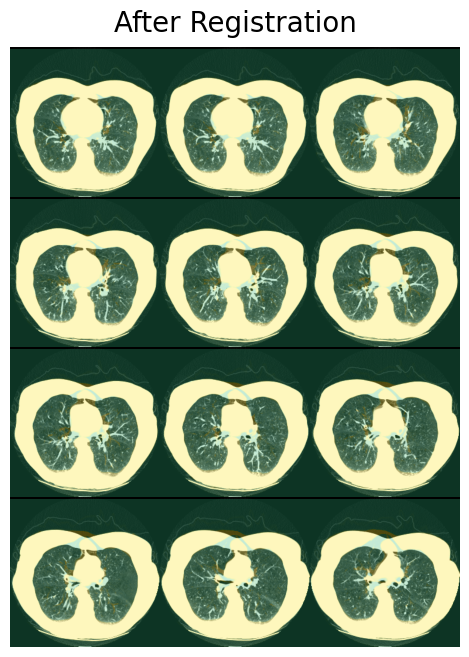

In [45]:
warped_moving = mytx['warpedmovout']
fixed.plot(overlay=warped_moving, cmap='gray', overlay_cmap='viridis', overlay_alpha=0.3, title='After Registration', axis=2)

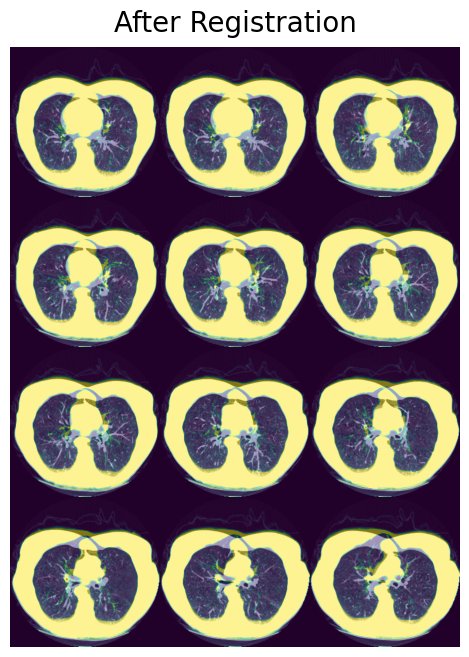

In [48]:
def_field = ants.image_read(mytx['fwdtransforms'][0])
fwdtransform = ants.transform_from_displacement_field(def_field)
mywarped = fwdtransform.apply_to_image(moving)
fixed.plot(overlay=mywarped, cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, title='After Registration', axis=2)